In [159]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [2]:
#other useful imports 
import numpy as np
import scipy as sp
import scipy.stats as stats
import h5py

from utils import featurewise_norm

from sklearn.decomposition import PCA

In [3]:
#ok let's load our usual data 
DATA_PATH = "/home/chengxuz/Class/psych253_2018/data/ventral_neural_data.hdf5"
Ventral_Dataset = h5py.File(DATA_PATH)

In [4]:
Neural_Data = Ventral_Dataset['time_averaged_trial_averaged'][:]
IT_NEURONS = Ventral_Dataset['neural_meta']['IT_NEURONS']
V4_NEURONS = Ventral_Dataset['neural_meta']['V4_NEURONS']
V4_Neural_Data = Neural_Data[:, V4_NEURONS]
IT_Neural_Data = Neural_Data[:, IT_NEURONS]

var_level = Ventral_Dataset['image_meta']['variation_level'][:]
categories = Ventral_Dataset['image_meta']['category'][:]   #array of category labels for all images  --> shape == (5760,)
unique_categories = np.unique(categories)                #array of unique category labels --> shape == (8,)
objects = Ventral_Dataset['image_meta']['object_name'][:]   #array of object labels for all images --> shape == (5670,)
unique_objects = np.unique(objects)                      #array of unique object labels --> shape == (64,) 

objects_by_category = {c: np.unique(objects[categories == c]) 
                       for c in unique_categories}


In [5]:
#use numpy recarray object to store metadata 
meta_array = np.core.records.fromarrays(Ventral_Dataset['image_meta'].values(),
                                        names=Ventral_Dataset['image_meta'].keys())

meta_array.dtype


dtype((numpy.record, [(u'category', 'S7'), (u'image_id', 'S40'), (u'object_name', 'S24'), (u'rotation_xy', '<f8'), (u'rotation_xz', '<f8'), (u'rotation_yz', '<f8'), (u'size', '<f8'), (u'translation_y', '<f8'), (u'translation_z', '<f8'), (u'variation_level', 'S2')]))

### K means clustering

In [383]:
from scipy.spatial.distance import cdist

def get_initial_means(data, k):
    """This initialization procedure simply picks k random datapoints 
    as the initial guess for k cluster (this is called "Forgy's method").
    """
    rng = np.random.RandomState(seed=1)
    perm = rng.permutation(len(data))
    means = data[perm[: k]]
    return means

def kmeans(data, k, tol=1e-5, distfunc='euclidean'):
    """This implements a procedure called "Lloyds algorithm"
    """
    #get inital means
    means = get_initial_means(data, k)
    
    #now, iteratively ... 
    means0 = means.copy()
    iterv = 0
    while True:
        #find the assignment of each point to cluster by minimum distance
        dists = cdist(data, means, distfunc)
        assignments = dists.argmin(axis=1)        
        
        #then update means of cluster
        for j in range(k):
            means[j] = data[assignments==j].mean(axis=0)
        
        #stopping criteria
        diffs = np.sqrt(((means0 - means)**2).sum(axis=1))
        if diffs.max() < tol:
            print('Stopping at iter %d with dist %.3f' % (iterv, diffs.max()))
            break
        means0 = means.copy()
        iterv += 1
            
    return assignments
            

In [384]:
def numerize(x, c):
    n = np.zeros(len(x)).astype(np.int)
    for i, cv in enumerate(c):
        n[x == cv] = i
    return n

In [406]:
def visualize_clustering(data, assignments, ground_truth, label):
    #data might be high-dimensional of shape (n, m)
    #assignments is a vector mapping each of the n data points to [1, ... k] clusters
    #ground_truth = some actual categories 
    
    #computes a 3-dimensional projection of the data (n-->3) based on pca
    cls = PCA(n_components=3)
    cls.fit(data)
    data_proj3 = cls.transform(data_ss)    
    
    #plots the ground truth vs assignments in the 3d projection
    colors = np.array(['r', 'g', 'b', 'c', 'm', 'y', 'k', '#bbbfff'])
    fig=plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(121, projection='3d')
    xv, yv, zv = data_proj3.T
    ax.scatter(xv, yv, zv, c=colors[assignments], s=40)
    plt.title(label)
    ax = fig.add_subplot(122, projection='3d')
    ax.scatter(xv, yv, zv, c=colors[ground_truth], s=40)    
    plt.title("True categories")   

Stopping at iter 9 with dist 0.000


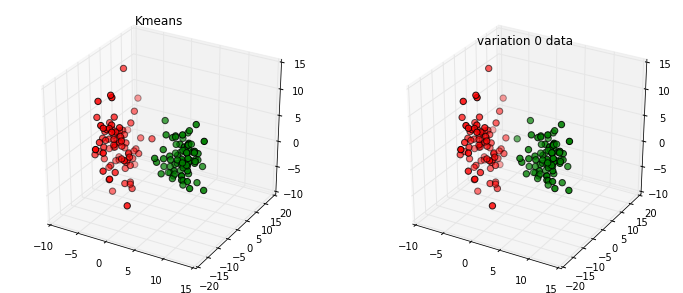

In [517]:
inds = meta_array['variation_level']=='V0'
inds = inds & ((meta_array['category'] == 'Animals') | (meta_array['category'] == 'Faces'))
data_ss, _ig, _ig = featurewise_norm(IT_Neural_Data[inds])
meta_ss = meta_array[inds]
cat_ss = meta_ss['category']
cat_ss_ind = numerize(cat_ss, np.unique(cat_ss))

assignments = kmeans(data=data_ss, k=2, distfunc='euclidean')

visualize_clustering(data_ss, assignments, cat_ss_ind, "Kmeans")
plt.title('variation 0 data')

Stopping at iter 10 with dist 0.000


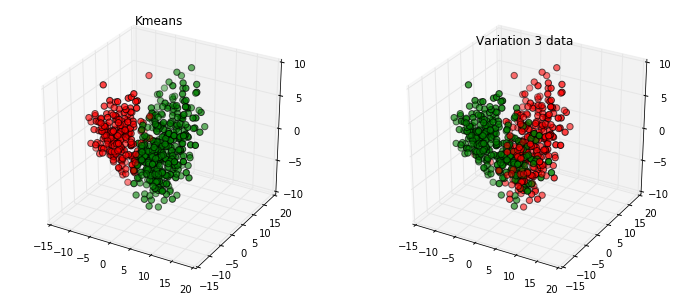

In [420]:
inds = meta_array['variation_level']=='V3'
inds = inds & ((meta_array['category'] == 'Animals') | (meta_array['category'] == 'Faces'))
data_ss, _ig, _ig = featurewise_norm(IT_Neural_Data[inds])
meta_ss = meta_array[inds]
cat_ss = meta_ss['category']
cat_ss_ind = numerize(cat_ss, np.unique(cat_ss))

assignments = kmeans(data=data_ss, k=2, distfunc='euclidean')

visualize_clustering(data_ss, assignments, cat_ss_ind, "Kmeans")
plt.title('Variation 3 data')

Stopping at iter 7 with dist 0.000


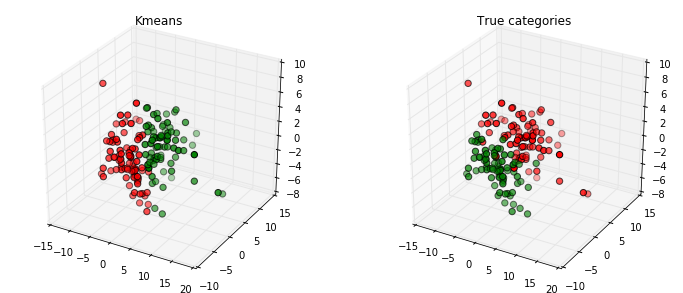

In [518]:
inds = meta_array['variation_level']=='V0'
inds = inds & ((meta_array['category'] == 'Animals') | (meta_array['category'] == 'Boats'))
data_ss, _ig, _ig = featurewise_norm(IT_Neural_Data[inds])
meta_ss = meta_array[inds]
cat_ss = meta_ss['category']
cat_ss_ind = numerize(cat_ss, np.unique(cat_ss))

assignments = kmeans(data=data_ss, k=2, distfunc='euclidean')

visualize_clustering(data_ss, assignments, cat_ss_ind, "Kmeans")

Stopping at iter 4 with dist 0.000


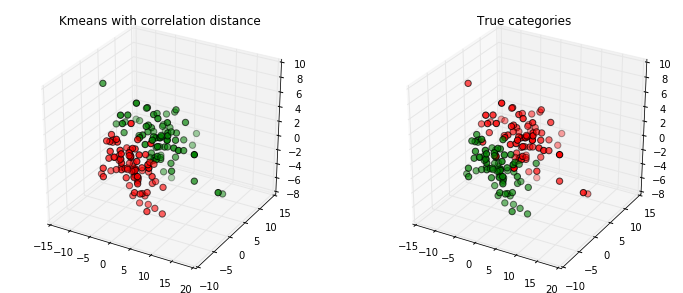

In [519]:
inds = meta_array['variation_level']=='V0'
inds = inds & ((meta_array['category'] == 'Animals') | (meta_array['category'] == 'Boats'))
data_ss, _ig, _ig = featurewise_norm(IT_Neural_Data[inds])
meta_ss = meta_array[inds]
cat_ss = meta_ss['category']
cat_ss_ind = numerize(cat_ss, np.unique(cat_ss))

assignments = kmeans(data=data_ss, k=2, distfunc='correlation')

visualize_clustering(data_ss, assignments, cat_ss_ind, "Kmeans with correlation distance")

Stopping at iter 2 with dist 0.000


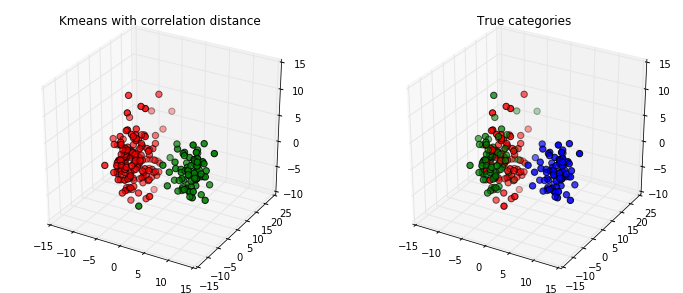

In [520]:
inds = meta_array['variation_level']=='V0'
inds = inds & ((meta_array['category'] == 'Animals') | (meta_array['category'] == 'Cars') 
               | (meta_array['category'] == 'Faces'))
data_ss, _ig, _ig = featurewise_norm(IT_Neural_Data[inds])
meta_ss = meta_array[inds]
cat_ss = meta_ss['category']
cat_ss_ind = numerize(cat_ss, np.unique(cat_ss))

assignments = kmeans(data=data_ss, k=2, distfunc='correlation')

visualize_clustering(data_ss, assignments, cat_ss_ind, "Kmeans with correlation distance")

Stopping at iter 6 with dist 0.000


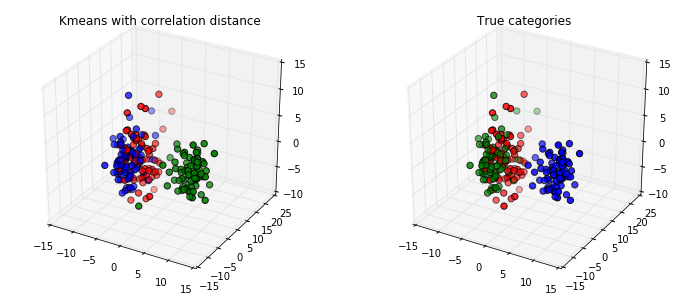

In [521]:
inds = meta_array['variation_level']=='V0'
inds = inds & ((meta_array['category'] == 'Animals') | (meta_array['category'] == 'Cars') 
               | (meta_array['category'] == 'Faces'))
data_ss, _ig, _ig = featurewise_norm(IT_Neural_Data[inds])
meta_ss = meta_array[inds]
cat_ss = meta_ss['category']
cat_ss_ind = numerize(cat_ss, np.unique(cat_ss))

assignments = kmeans(data=data_ss, k=3, distfunc='correlation')

visualize_clustering(data_ss, assignments, cat_ss_ind, "Kmeans with correlation distance")

Stopping at iter 2 with dist 0.000


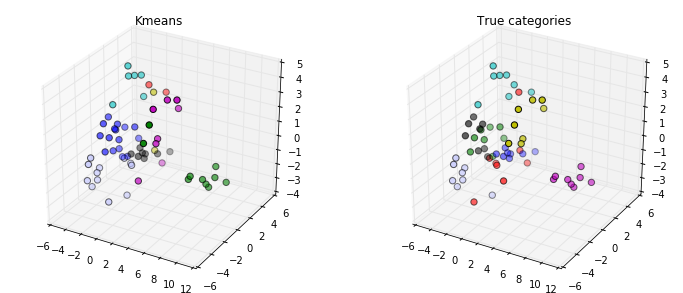

In [524]:
#let's look at data in average
inds = meta_array['variation_level']=='V3'
data_ss, _ig, _ig = featurewise_norm(IT_Neural_Data[inds])
meta_ss = meta_array[inds]
data_ss = np.row_stack([[data_ss[meta_ss['object_name'] == o].mean(0) for o in objects_by_category[cat]] 
   for cat in unique_categories])
cat_ss = np.concatenate([[meta_ss[meta_ss['object_name'] == o]['category'][0] for o in objects_by_category[cat]]
   for cat in unique_categories])
cat_ss_ind = numerize(cat_ss, np.unique(cat_ss))

#actually run kmeans on the data
assignments = kmeans(data=data_ss, k=8, distfunc='correlation')

#plot
visualize_clustering(data_ss, assignments, cat_ss_ind, "Kmeans")

In [344]:
from sklearn.cluster import KMeans

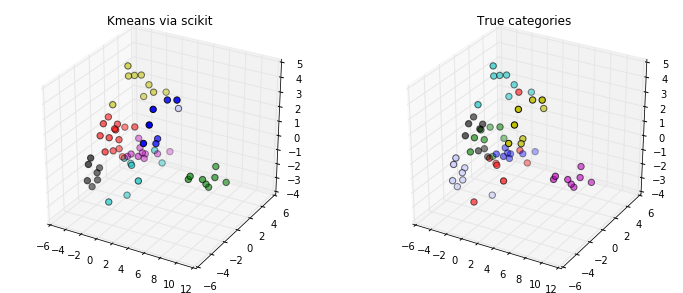

In [523]:
#do it the scikit-learn way
cls_km = KMeans(n_clusters=8)
assignments = cls_km.fit_predict(data_ss)

visualize_clustering(data_ss, assignments, cat_ss_ind, "Kmeans via scikit")

### Other clustering Methods

In [346]:
from sklearn.cluster import AgglomerativeClustering

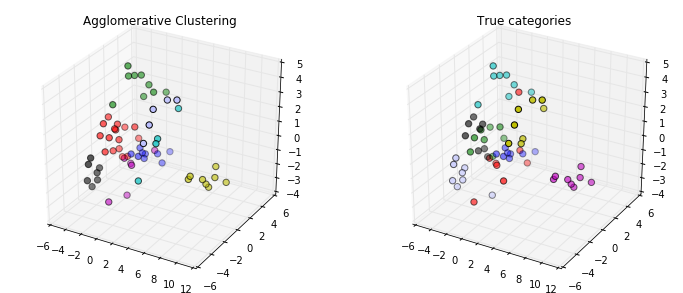

In [413]:
inds = meta_array['variation_level']=='V3'
data_ss, _ig, _ig = featurewise_norm(IT_Neural_Data[inds])
meta_ss = meta_array[inds]
data_ss = np.row_stack([[data_ss[meta_ss['object_name'] == o].mean(0) for o in objects_by_category[cat]] 
   for cat in unique_categories])
cat_ss = np.concatenate([[meta_ss[meta_ss['object_name'] == o]['category'][0] for o in objects_by_category[cat]]
   for cat in unique_categories])
cat_ss_ind = numerize(cat_ss, np.unique(cat_ss))

cls_km = AgglomerativeClustering(n_clusters=8)
assignments = cls_km.fit_predict(data_ss)

visualize_clustering(data_ss, assignments, cat_ss_ind, "Agglomerative Clustering")

In [324]:
from sklearn.cluster import AffinityPropagation

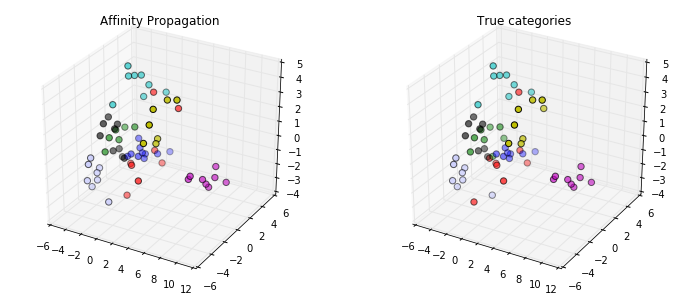

In [532]:
cls_km = AffinityPropagation(damping=.8)
assignments = cls_km.fit_predict(data_ss)

visualize_clustering(data_ss, assignments, cat_ss_ind, "Affinity Propagation")

### Gaussian Mixture Models

In [349]:
from sklearn.mixture import GaussianMixture

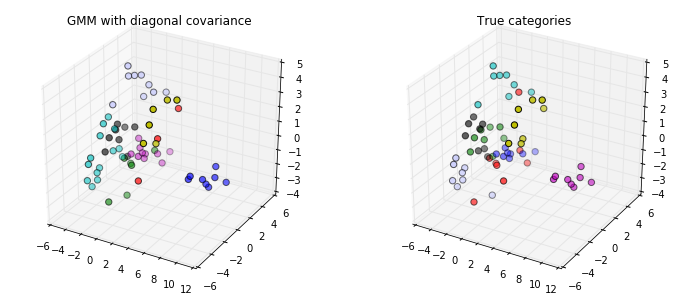

In [533]:
inds = meta_array['variation_level'] == 'V3'
data_ss, _ig, _ig = featurewise_norm(IT_Neural_Data[inds])
meta_ss = meta_array[inds]
data_ss = np.row_stack([[data_ss[meta_ss['object_name'] == o].mean(0) for o in objects_by_category[cat]] 
   for cat in unique_categories])
cat_ss = np.concatenate([[meta_ss[meta_ss['object_name'] == o]['category'][0] for o in objects_by_category[cat]]
   for cat in unique_categories])
cat_ss_ind = numerize(cat_ss, np.unique(cat_ss))

cls_km = GaussianMixture(n_components=8, covariance_type='diag')
cls_km.fit(data_ss)
assignments = cls_km.predict(data_ss)

visualize_clustering(data_ss, assignments, cat_ss_ind, "GMM with diagonal covariance")

In [474]:
cls_km.means_.shape

(8, 168)

In [475]:
cls_km.covariances_.shape

(8, 168)

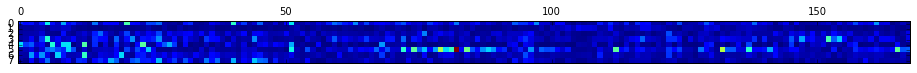

In [476]:
plt.matshow(cls_km.covariances_)

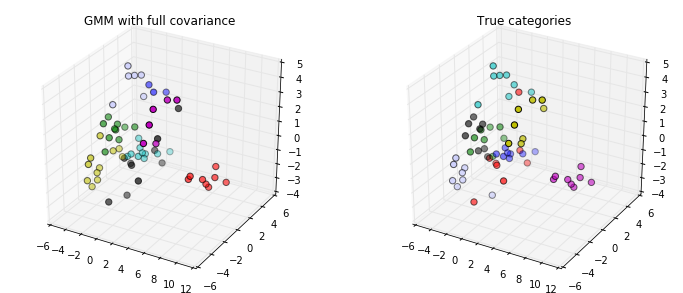

In [535]:
cls_km = GaussianMixture(n_components=8, covariance_type='full')
cls_km.fit(data_ss)
assignments = cls_km.predict(data_ss)

visualize_clustering(data_ss, assignments, cat_ss_ind, "GMM with full covariance")

In [536]:
#shape is numclusters, num_features, num_features
cls_km.covariances_.shape

(8, 168, 168)

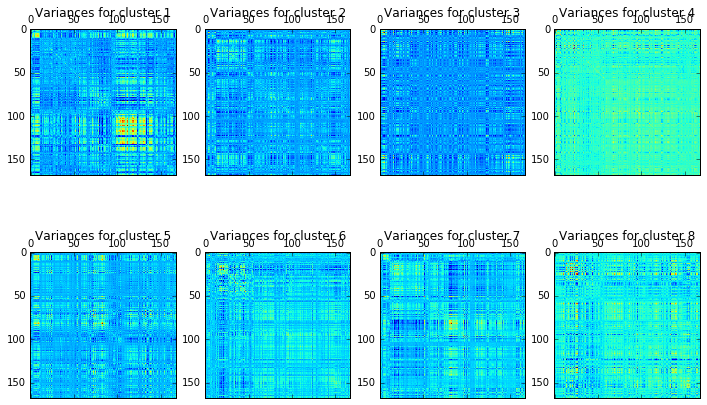

In [537]:
plt.figure(figsize=(12, 8))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.gca().matshow(cls_km.covariances_[i])
    plt.title('Variances for cluster %d' % (i+1))
plt.subplots_adjust(hspace=.00)

#### Bayesian GMMs

In [356]:
from sklearn.mixture import BayesianGaussianMixture

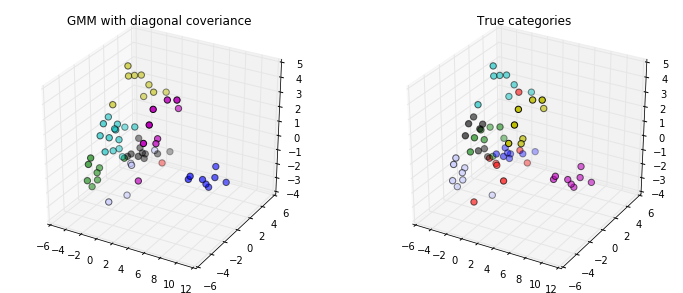

In [445]:
inds = meta_array['variation_level'] == 'V3'
data_ss, _ig, _ig = featurewise_norm(IT_Neural_Data[inds])
meta_ss = meta_array[inds]
data_ss = np.row_stack([[data_ss[meta_ss['object_name'] == o].mean(0) for o in objects_by_category[cat]] 
   for cat in unique_categories])
cat_ss = np.concatenate([[meta_ss[meta_ss['object_name'] == o]['category'][0] for o in objects_by_category[cat]]
   for cat in unique_categories])
cat_ss_ind = numerize(cat_ss, np.unique(cat_ss))

cls_km = BayesianGaussianMixture(n_components=8, covariance_type='diag')
cls_km.fit(data_ss)
assignments = cls_km.predict(data_ss)

visualize_clustering(data_ss, assignments, cat_ss_ind, "Bayesian GMM with diagonal coveriance")

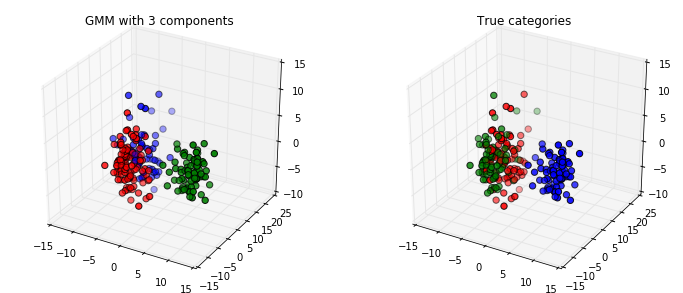

In [506]:
inds = meta_array['variation_level']=='V0'
inds = inds & ((meta_array['category'] == 'Animals') | (meta_array['category'] == 'Cars') 
               | (meta_array['category'] == 'Faces'))
data_ss, _ig, _ig = featurewise_norm(IT_Neural_Data[inds])
meta_ss = meta_array[inds]
cat_ss = meta_ss['category']
cat_ss_ind = numerize(cat_ss, np.unique(cat_ss))


cls_km = GaussianMixture(n_components=3, covariance_type='diag')
cls_km.fit(data_ss)
assignments = cls_km.predict(data_ss)

visualize_clustering(data_ss, assignments, cat_ss_ind, "GMM with 3 components")

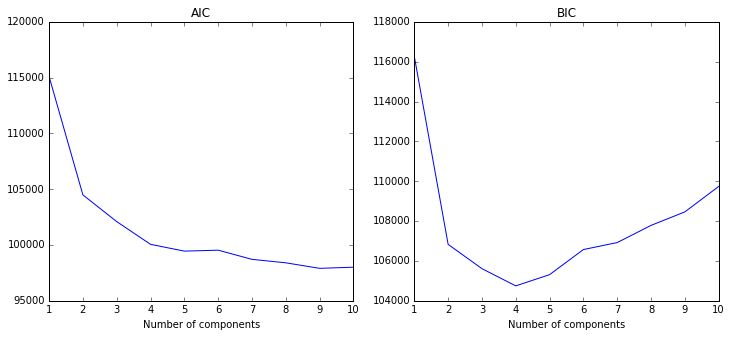

In [490]:
inds = meta_array['variation_level']=='V0'
inds = inds & ((meta_array['category'] == 'Animals') | (meta_array['category'] == 'Cars') 
               | (meta_array['category'] == 'Faces'))
data_ss, _ig, _ig = featurewise_norm(IT_Neural_Data[inds])
meta_ss = meta_array[inds]
cat_ss = meta_ss['category']
cat_ss_ind = numerize(cat_ss, np.unique(cat_ss))

aics = []
bics = []
ncomps = range(1, 11)
for n in ncomps:
    cls = GaussianMixture(n_components=n, covariance_type='diag')
    cls.fit(data_ss)
    aics.append(cls.aic(data_ss))
    bics.append(cls.bic(data_ss))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(ncomps, aics)
plt.xlabel('Number of components')
plt.title('AIC')
plt.subplot(1, 2, 2)
plt.plot(ncomps, bics)
plt.xlabel('Number of components')
plt.title('BIC')


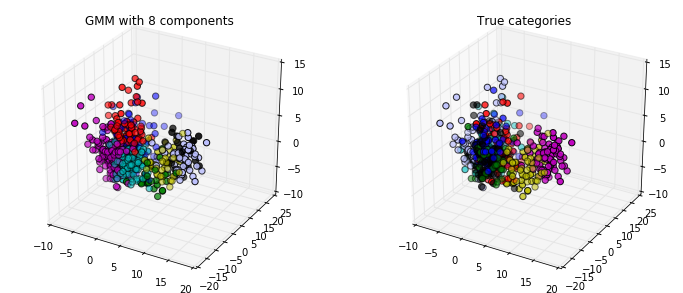

In [509]:
inds = meta_array['variation_level']=='V0'
data_ss, _ig, _ig = featurewise_norm(IT_Neural_Data[inds])
meta_ss = meta_array[inds]
cat_ss = meta_ss['category']
cat_ss_ind = numerize(cat_ss, np.unique(cat_ss))


cls_km = GaussianMixture(n_components=8, covariance_type='diag')
cls_km.fit(data_ss)
assignments = cls_km.predict(data_ss)

visualize_clustering(data_ss, assignments, cat_ss_ind, "GMM with 8 components")

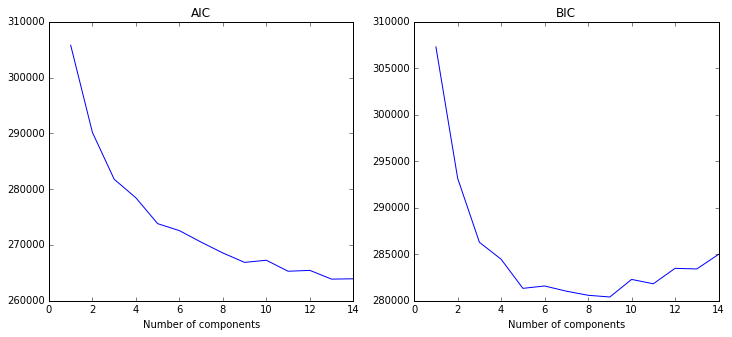

In [493]:
inds = meta_array['variation_level']=='V0'
data_ss, _ig, _ig = featurewise_norm(IT_Neural_Data[inds])
meta_ss = meta_array[inds]
cat_ss = meta_ss['category']
cat_ss_ind = numerize(cat_ss, np.unique(cat_ss))

aics = []
bics = []
ncomps = range(1, 15)
for n in ncomps:
    cls = GaussianMixture(n_components=n, covariance_type='diag')
    cls.fit(data_ss)
    aics.append(cls.aic(data_ss))
    bics.append(cls.bic(data_ss))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(ncomps, aics)
plt.xlabel('Number of components')
plt.title('AIC')
plt.subplot(1, 2, 2)
plt.plot(ncomps, bics)
plt.xlabel('Number of components')
plt.title('BIC')


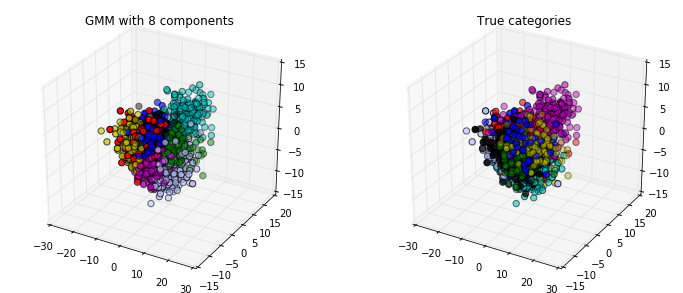

In [510]:
inds = meta_array['variation_level']=='V3'
data_ss, _ig, _ig = featurewise_norm(IT_Neural_Data[inds])
meta_ss = meta_array[inds]
cat_ss = meta_ss['category']
cat_ss_ind = numerize(cat_ss, np.unique(cat_ss))


cls_km = GaussianMixture(n_components=8, covariance_type='diag')
cls_km.fit(data_ss)
assignments = cls_km.predict(data_ss)

visualize_clustering(data_ss, assignments, cat_ss_ind, "GMM with 8 components")

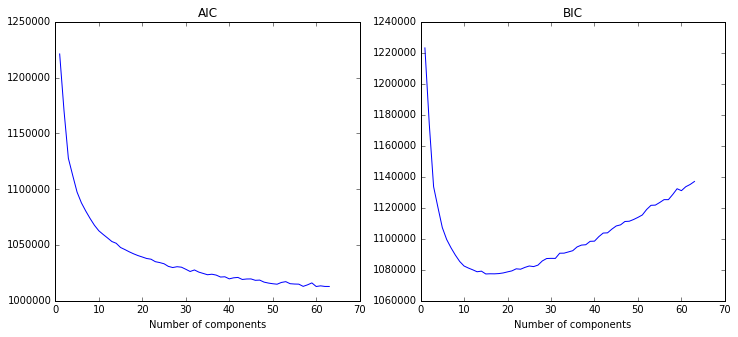

In [499]:
inds = meta_array['variation_level']=='V3'
data_ss, _ig, _ig = featurewise_norm(IT_Neural_Data[inds])
meta_ss = meta_array[inds]
cat_ss = meta_ss['category']
cat_ss_ind = numerize(cat_ss, np.unique(cat_ss))

aics = []
bics = []
ncomps = range(1, 64)
for n in ncomps:
    cls = GaussianMixture(n_components=n, covariance_type='diag')
    cls.fit(data_ss)
    aics.append(cls.aic(data_ss))
    bics.append(cls.bic(data_ss))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(ncomps, aics)
plt.xlabel('Number of components')
plt.title('AIC')
plt.subplot(1, 2, 2)
plt.plot(ncomps, bics)
plt.xlabel('Number of components')
plt.title('BIC')


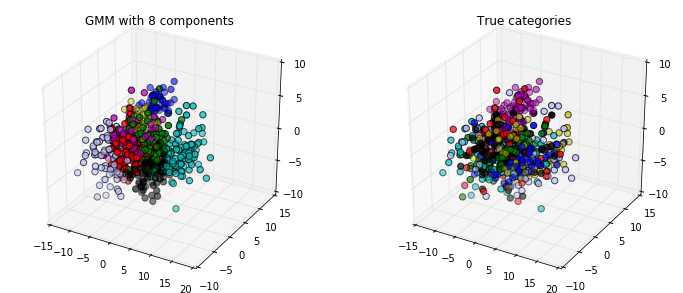

In [516]:
inds = meta_array['variation_level']=='V0'
data_ss, _ig, _ig = featurewise_norm(V4_Neural_Data[inds])
meta_ss = meta_array[inds]
cat_ss = meta_ss['category']
cat_ss_ind = numerize(cat_ss, np.unique(cat_ss))


cls_km = GaussianMixture(n_components=8, covariance_type='diag')
cls_km.fit(data_ss)
assignments = cls_km.predict(data_ss)

visualize_clustering(data_ss, assignments, cat_ss_ind, "GMM with 8 components")

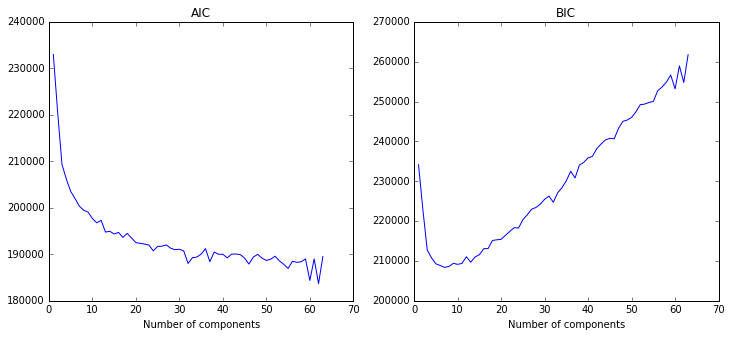

In [515]:
inds = meta_array['variation_level']=='V0'
data_ss, _ig, _ig = featurewise_norm(V4_Neural_Data[inds])
meta_ss = meta_array[inds]
cat_ss = meta_ss['category']
cat_ss_ind = numerize(cat_ss, np.unique(cat_ss))

aics = []
bics = []
ncomps = range(1, 64)
for n in ncomps:
    cls = GaussianMixture(n_components=n, covariance_type='diag')
    cls.fit(data_ss)
    aics.append(cls.aic(data_ss))
    bics.append(cls.bic(data_ss))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(ncomps, aics)
plt.xlabel('Number of components')
plt.title('AIC')
plt.subplot(1, 2, 2)
plt.plot(ncomps, bics)
plt.xlabel('Number of components')
plt.title('BIC')
